# Integrated Simulations

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
from skimage.io import imread
from skimage.exposure import rescale_intensity
import numpy as np 
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
import seaborn as sns
import rsnapsim as rss
import scipy.stats as stats
import matplotlib.pyplot as plt 

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
trajectories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','kdm5b_ssa.npy')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')
gene_file = current_dir.parents[1].joinpath('DataBases','gene_files','KDM5B_withTags.txt')
masks_dir = current_dir.parents[1].joinpath('DataBases','masks_for_sim_cell')

In [3]:
# Importing rSNAPed
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [4]:
rsp.Banner().print_banner()

 
  ██████╗░░██████╗███╗░░██╗░█████╗░██████╗░███████╗██████╗░ 
  ██╔══██╗██╔════╝████╗░██║██╔══██╗██╔══██╗██╔════╝██╔══██╗ 
  ██████╔╝╚█████╗░██╔██╗██║███████║██████╔╝█████╗░░██║░░██║ 
  ██╔══██╗░╚═══██╗██║╚████║██╔══██║██╔═══╝░██╔══╝░░██║░░██║ 
  ██║░░██║██████╔╝██║░╚███║██║░░██║██║░░░░░███████╗██████╔╝ 
             by : L. Aguilera, T. Stasevich, and B. Munsky 


In [5]:
# These are the parameters that need to be tested. 
number_of_simulated_cells = 8       # PLEASE TEST MIN 1 MAX 10
number_spots_per_cell = 40           # PLEASE TEST MIN 5 MAX 200
simulation_time_in_sec = 30          # PLEASE TEST MIN 10 MAX 100
diffusion_coefficient = 0.5          # PLEASE TEST MIN 0.1 MAX 2
min_percentage_time_tracking = 0.3   # (normalized) minimum time to consider a trajectory.
average_cell_diameter = 400

In [6]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 1 # 0 not using, 1 is using optimization
frame_selection_empty_video = 'generate_from_gaussian' # Options are: 'constant' , 'shuffle' and 'loop' 'linear_interpolation'
show_plot = 1  # Flag to show plots for the detection and tracking process.
dataframe_format = 'long' # 'short'  'long'
rna_intensity_method='random_values'   # 'constant'   ,   'random_values'

In [7]:
particle_size = 5 # spot size for the simulation and tracking.
elongation_rate = 10
initiation_rate = 0.03

In [8]:
intensity_scale_ch0 = 200
intensity_scale_ch1 = 400
intensity_scale_ch2 = None

In [9]:
particle_detection_size = particle_size

In [10]:
def simulate_rna_intensity(shape=(number_spots_per_cell, simulation_time_in_sec),rna_intensity_method='constant',min_int=None,max_int=None,mean_int=None):
    if rna_intensity_method =='random_values':
        rna_intensities = np.random.uniform(low=min_int, high=max_int, size=shape) 
    elif rna_intensity_method =='constant':
        rna_intensities = np.full(shape=shape, fill_value= mean_int)
    return rna_intensities

In [11]:
def rsnapsim_ssa(gene_file,ke,ki,frames=300,frame_rate=1,n_traj=20):
    '''
    This function uses rsnapsim to simulate the single-molecule translation dynamics of any gene.
    Inputs:
    gene_file : str, with the location of a FASTA file.
    ke : float, elongation rate.
    ki: float, initiation rate.
    frames: int, total number of simulation frames in seconds.
    n_traj: int, number of trajectories to simulate
    frame_rate : int, frame rate per second
    Outputs:
    ssa_int : NumPy array with dimensions [Time_points, simulated_trajectories]
    '''
    poi_strs, poi_objs, tagged_pois,raw_seq = rss.seqmanip.open_seq_file(str(gene_file))
    gene_obj = tagged_pois['1'][0]
    gene_obj.ke_mu = ke
    rss.solver.protein = gene_obj #pass the protein object
    t_burnin = 1000
    t = np.linspace(0,t_burnin+frames,(t_burnin+frames+1)*(frame_rate))
    number_probes = np.amax(gene_obj.probe_vec)
    ints = []
    counter = 0
    while counter < n_traj:
      ssa_solution = rss.solver.solve_ssa(gene_obj.kelong, t, ki=ki, kt = ke, low_memory=True,record_stats=False,n_traj=1)
      ssa_int =  ssa_solution.intensity_vec[0,t_burnin*frame_rate:-1,:]
      if np.mean(ssa_int)> 1:
        ints.append(ssa_int)
        counter +=1
    ssa = np.array(ints).reshape(n_traj,frames) #flatten the lists back to a numpy array

    ssa_ump = ssa/number_probes
    return ssa, ssa_ump, gene_obj, t,number_probes

## Running the simulations

In [12]:
def fun_simulated_cells(current_dir, video_dir,masks_dir=None,ke=3,ki=0.03,gene_file =None, trajectories_dir=None, number_of_simulated_cells=3,number_spots_per_cell=80,simulation_time_in_sec =100,step_size_in_sec=1,particle_size=5, diffusion_coefficient =1, path_to_save_output='temp',intensity_calculation_method='gaussian_fit',frame_selection_empty_video='shuffle',dataframe_format='long',rna_intensity_method='constant'):
    spot_size = particle_size
    spot_sigma = 1
    # Code that creates the folder to store results.
    diffusion_coefficient_string = str(diffusion_coefficient).replace('.','_')
    directory_name = 'Simulation_V2__'+'ns_'+str(number_spots_per_cell) +'_diff_'+ diffusion_coefficient_string 
    path_to_save_output = 'temp'
    save_to_path =  current_dir.joinpath(path_to_save_output , directory_name )
    if not os.path.exists(str(save_to_path)):
        os.makedirs(str(save_to_path))
    else:
        shutil.rmtree(str(save_to_path))
        os.makedirs(str(save_to_path))
    counter = 0
    ## Main loop that creates each cell and dataframe
    for cell_number in range (0, number_of_simulated_cells):
        output_directory_name = str(video_dir)
        list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
        list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
        path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
        video_path = path_files[counter]        
        video = imread(str(video_path)) 
        # Loading the mask image
        if not (masks_dir is None):
            mask_image=imread(masks_dir.joinpath('mask_cell_shape_'+str(counter)+'.tif'))        
        counter +=1
        if counter>=len(path_files):
            counter =0
        if not (trajectories_dir is None ):
            # Loading trajectories from file
            ssa_trajectories = np.load(str(trajectories_dir))
            random_index_ch0 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            random_index_ch1 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            random_index_ch2 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            simulated_trajectories_ch0 = ssa_trajectories[random_index_ch0,0:simulation_time_in_sec:step_size_in_sec]
            simulated_trajectories_ch1 = ssa_trajectories[random_index_ch1,0:simulation_time_in_sec:step_size_in_sec]
            simulated_trajectories_ch2 =  ssa_trajectories[random_index_ch2,0:simulation_time_in_sec:step_size_in_sec]
        else:
            # Simulations for intensity
            ssa1,ssa1_ump,_,_,number_probes = rsnapsim_ssa(gene_file,ke,ki,frames=simulation_time_in_sec,frame_rate=1,n_traj=number_spots_per_cell) # rss.ssa_solver(n_traj = number_spots_per_cell, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
            simulated_trajectories_ch1 = ssa1_ump
            ssa2,ssa2_ump,_,_,number_probes =  rsnapsim_ssa(gene_file,ke,ki,frames=simulation_time_in_sec,frame_rate=1,n_traj=number_spots_per_cell) # rss.ssa_solver(n_traj = number_spots_per_cell, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
            simulated_trajectories_ch2 = ssa2_ump
            # making a random vector with intensities for the RNA channel. 
            max_int_in_ssa =simulated_trajectories_ch1.max()
            min_int_in_ssa = simulated_trajectories_ch1.min()
            mean_int_in_ssa = simulated_trajectories_ch1.mean()
            simulated_trajectories_ch0 =    rsp.SimulateRNA(shape_output_array=(number_spots_per_cell, simulation_time_in_sec), rna_intensity_method='constant',min_int=min_int_in_ssa,max_int=max_int_in_ssa,mean_int=mean_int_in_ssa ).simulate()
            #simulated_trajectories_ch0= simulate_rna_intensity(shape=(number_spots_per_cell, simulation_time_in_sec),rna_intensity_method=rna_intensity_method,min_int=min_int_in_ssa,max_int=max_int_in_ssa,mean_int=mean_int_in_ssa)
        # Running the cell simulation
        saved_file_name = str(save_to_path.joinpath('sim_cell_'+str(cell_number)))
        tensor_video , spot_positions_movement, DataFrame_particles_intensities = rsp.SimulatedCell( base_video=video, mask_image=mask_image, number_spots = number_spots_per_cell, number_frames=simulation_time_in_sec, step_size=step_size_in_sec, diffusion_coefficient =diffusion_coefficient, simulated_trajectories_ch0=simulated_trajectories_ch0, size_spot_ch0=spot_size, spot_sigma_ch0=spot_sigma, simulated_trajectories_ch1=simulated_trajectories_ch1, size_spot_ch1=spot_size, spot_sigma_ch1=spot_sigma, simulated_trajectories_ch2=simulated_trajectories_ch2, size_spot_ch2=spot_size, spot_sigma_ch2=spot_sigma, ignore_ch0=0,ignore_ch1=0, ignore_ch2=1,save_as_tif_uint8=0,save_as_tif =1,save_as_gif=0, save_dataframe=1, saved_file_name=saved_file_name,create_temp_folder = False, intensity_calculation_method=intensity_calculation_method,perform_video_augmentation=1,frame_selection_empty_video=frame_selection_empty_video ,intensity_scale_ch0 = intensity_scale_ch0,intensity_scale_ch1 = intensity_scale_ch1,intensity_scale_ch2 = intensity_scale_ch2,dataframe_format=dataframe_format).make_simulation()      
        #print ('The results are saved in folder: ', saved_file_name)
    return save_to_path, simulated_trajectories_ch0, simulated_trajectories_ch1, simulated_trajectories_ch2

In [13]:
# output_directory_name = str(video_dir)
# list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
# path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
# counter=1
# video_path = path_files[counter]        
# video = imread(str(video_path)) 
# video.shape
# plt.imshow(video[0,:,:,0])
# plt.show()
# plt.imshow(video[0,:,:,1])
# plt.show()

In [14]:
# running the simulation
start = timer()
output_directory_name, simulated_trajectories_ch0, simulated_trajectories_ch1, simulated_trajectories_ch2 = fun_simulated_cells(current_dir,video_dir,masks_dir,ke=elongation_rate, ki=initiation_rate,trajectories_dir=None,gene_file= gene_file, number_of_simulated_cells=number_of_simulated_cells,number_spots_per_cell=number_spots_per_cell,simulation_time_in_sec =simulation_time_in_sec,step_size_in_sec=1,particle_size=particle_size, diffusion_coefficient=diffusion_coefficient,intensity_calculation_method=intensity_calculation_method,frame_selection_empty_video=frame_selection_empty_video,dataframe_format=dataframe_format,rna_intensity_method=rna_intensity_method)
end = timer()
print('Time to generate simulated data:',round(end - start), ' sec')

mean intensity in ssa: 4.7
Time to generate simulated data: 64  sec


In [15]:
output_directory_name

PosixPath('/home/luisub/Desktop/rsnaped/notebooks/Simulated_Cell/temp/Simulation_V2__ns_40_diff_0_5')

In [16]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(output_directory_name.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file

# Reading the microscopy data
number_images = number_of_simulated_cells

In [17]:
# Rescaling images
# rescale_video = False
# if rescale_video == True:
#     list_videos = []
#     number_channels = list_videos_original[0].shape[-1]
#     number_z_slices = list_videos_original[0].shape[0]
#     for i in range (0,number_images ):
#         temp_img = np.zeros_like(list_videos_original[0])
#         for j in range(0,number_channels):
#             temp_img[:,:,:,j] =  np.asarray( [ rescale_intensity(list_videos_original[i][z,:,:,j], in_range='image', out_range='dtype')  for z in range (0, number_z_slices)]  )
#         list_videos.append(temp_img)
# else:
#     list_videos = list_videos_original

In [18]:
# Reads the dataframes
list_dataframes_file_name = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.csv') in f], key=str.lower)  # reading all tif files in the folder
list_dataframes_file_name.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files_df = [ str(output_directory_name.joinpath(f).resolve()) for f in list_dataframes_file_name ] # creating the complete path for each file
list_df_real_positions = [pd.read_csv(f) for f in  path_files_df] # List with all the videos

# Display simulations for single time point

## <span style="color:red">Channel 0</span>

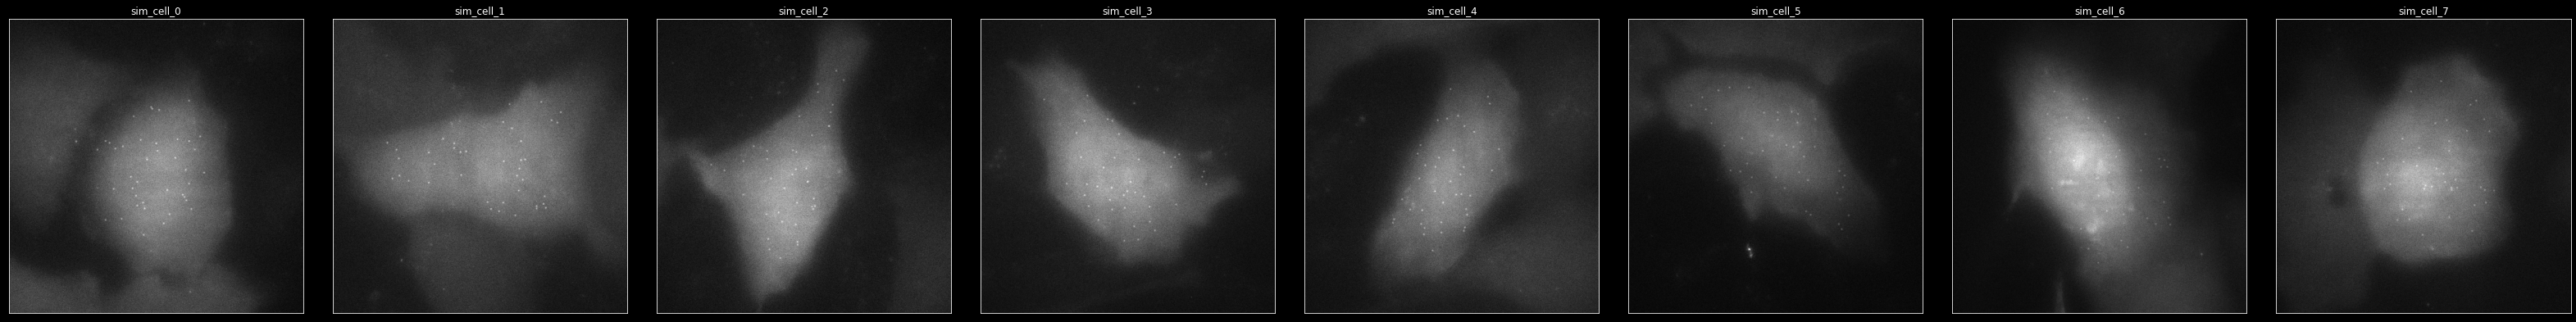

In [19]:
# Showing the simulated images
list_videos = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
rsp.VisualizerImage(list_videos,list_files_names=list_files_names,selected_channel =0,selected_time_point= 0,normalize=0,individual_figure_size=7).plot()

## <span style="color:lightgreen">Channel 1</span>

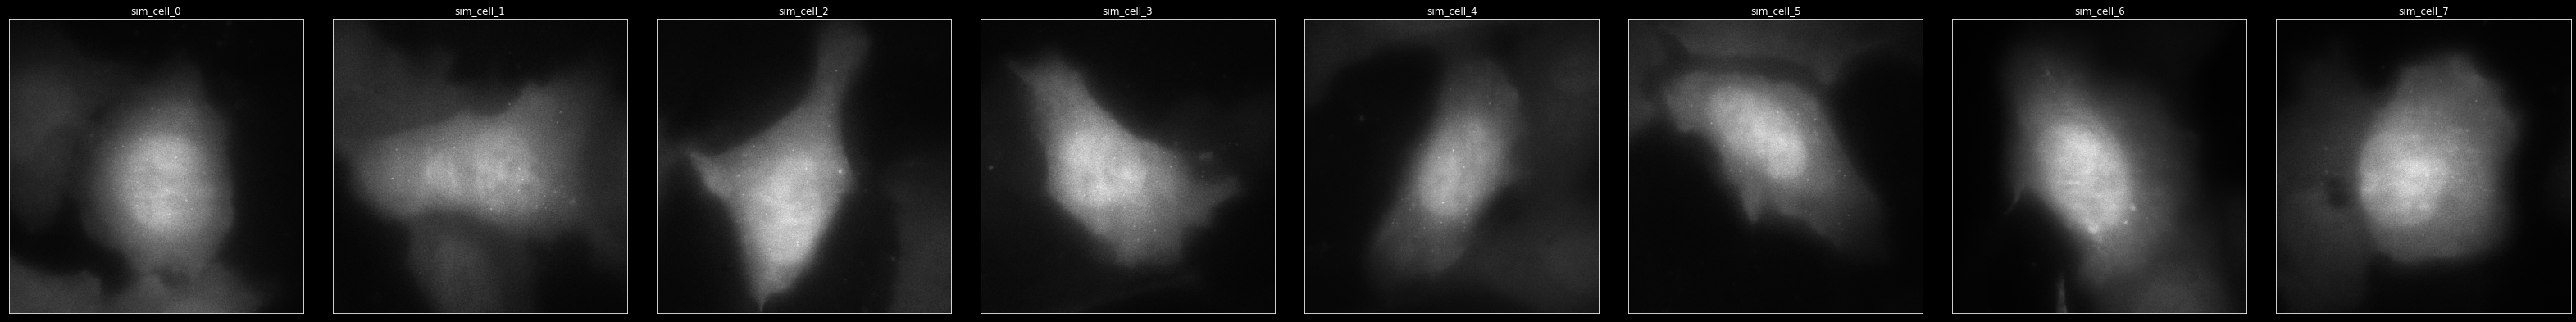

In [20]:
# Showing the simulated images
list_videos = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
rsp.VisualizerImage(list_videos,list_files_names=list_files_names,selected_channel =1,selected_time_point= 0,normalize=0,individual_figure_size=7).plot()
del list_videos

  0%|          | 0/8 [00:00<?, ?it/s]

mask time: 10  sec


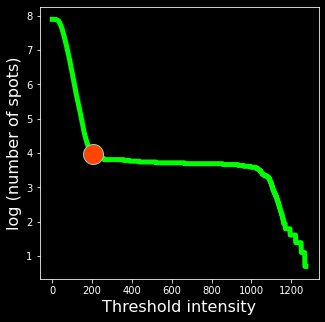

The number of detected trajectories is:  42
The selected intensity threshold is:  203.0 

tracking time: 5  sec
intensity calculation time: 1  sec


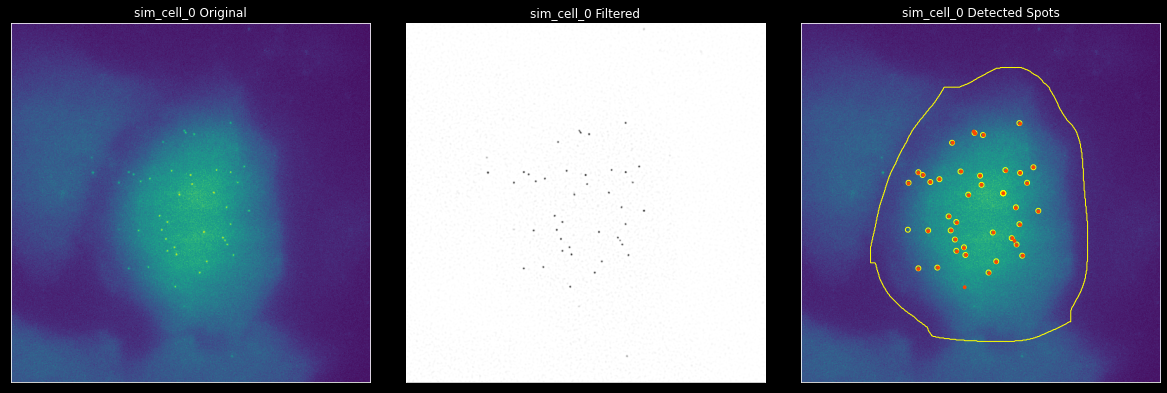

mask time: 6  sec


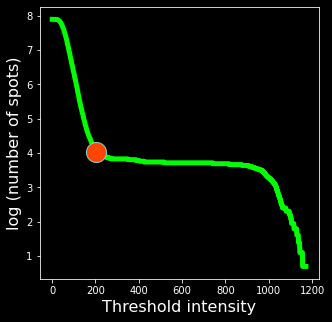

The number of detected trajectories is:  43
The selected intensity threshold is:  205.0 

tracking time: 3  sec
intensity calculation time: 1  sec


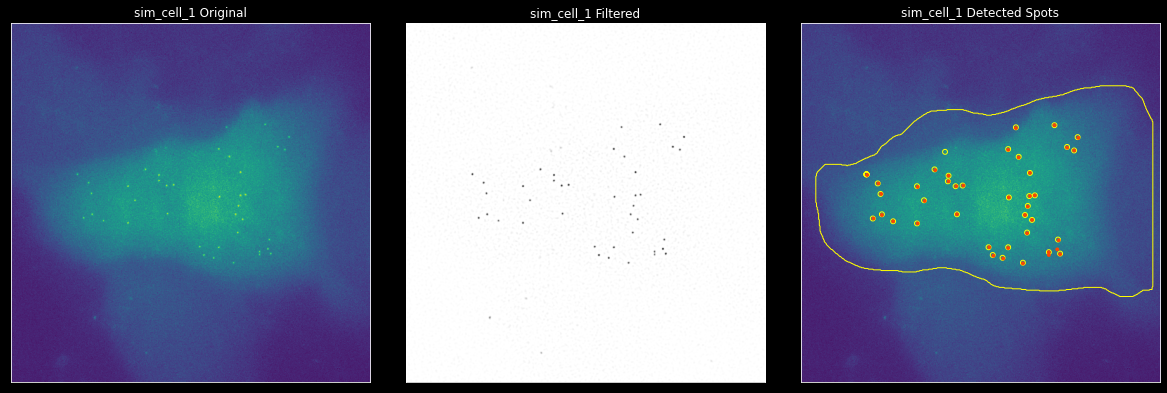

mask time: 7  sec


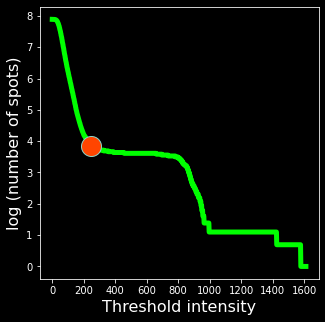

The number of detected trajectories is:  40
The selected intensity threshold is:  249.0 

tracking time: 4  sec
intensity calculation time: 1  sec


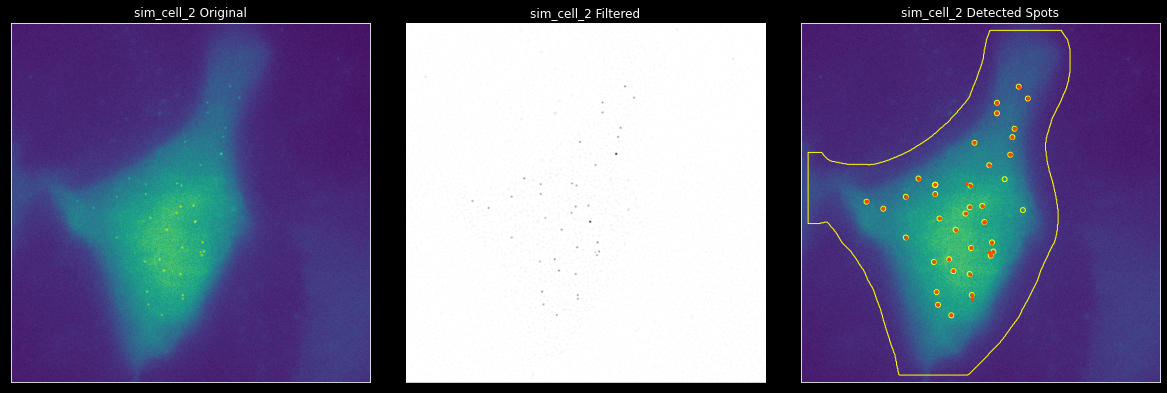

mask time: 7  sec


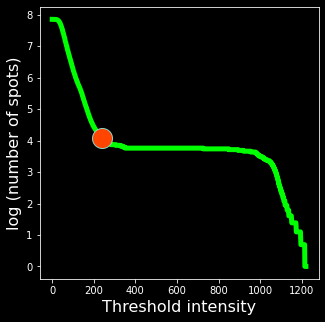

The number of detected trajectories is:  44
The selected intensity threshold is:  240.0 

tracking time: 4  sec
intensity calculation time: 1  sec


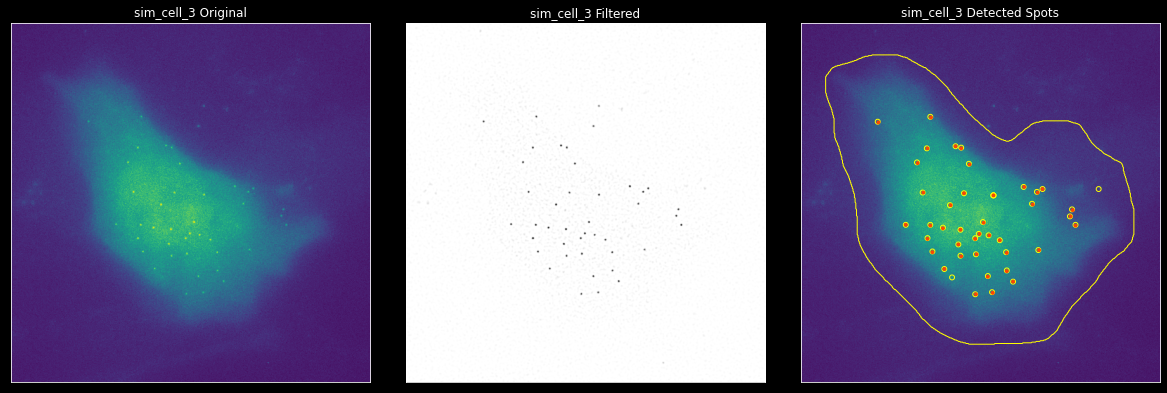

mask time: 7  sec


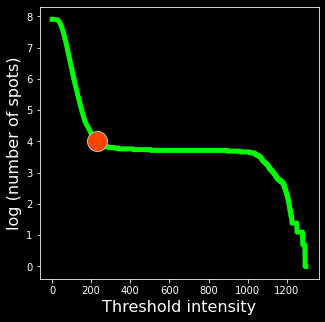

The number of detected trajectories is:  45
The selected intensity threshold is:  230.0 

tracking time: 4  sec
intensity calculation time: 1  sec


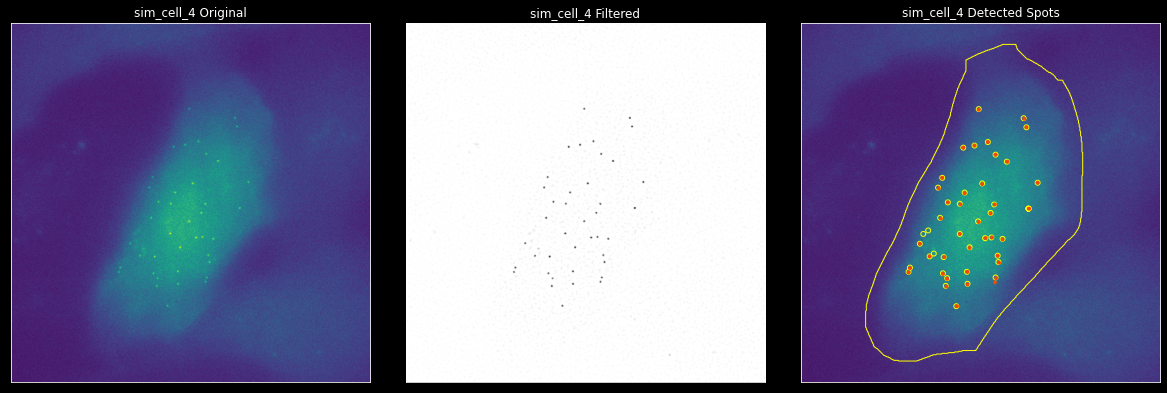

mask time: 7  sec


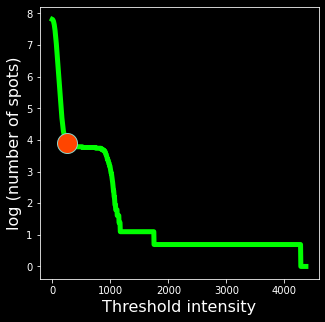

The number of detected trajectories is:  44
The selected intensity threshold is:  263.0 

tracking time: 3  sec
intensity calculation time: 1  sec


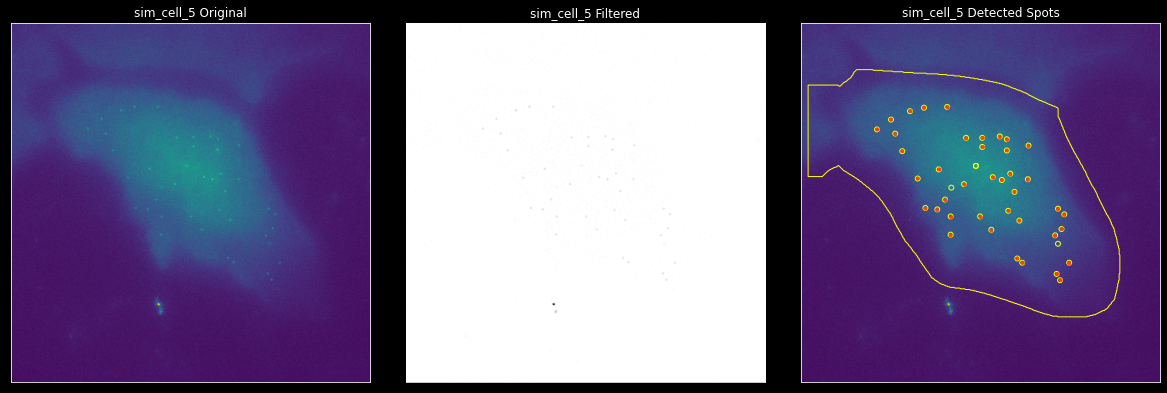

mask time: 6  sec


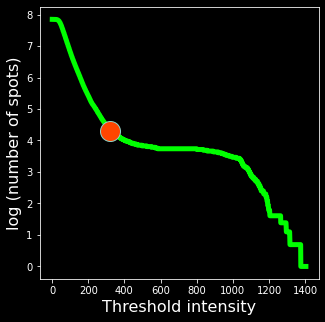

The number of detected trajectories is:  61
The selected intensity threshold is:  321.0 

tracking time: 4  sec
intensity calculation time: 1  sec


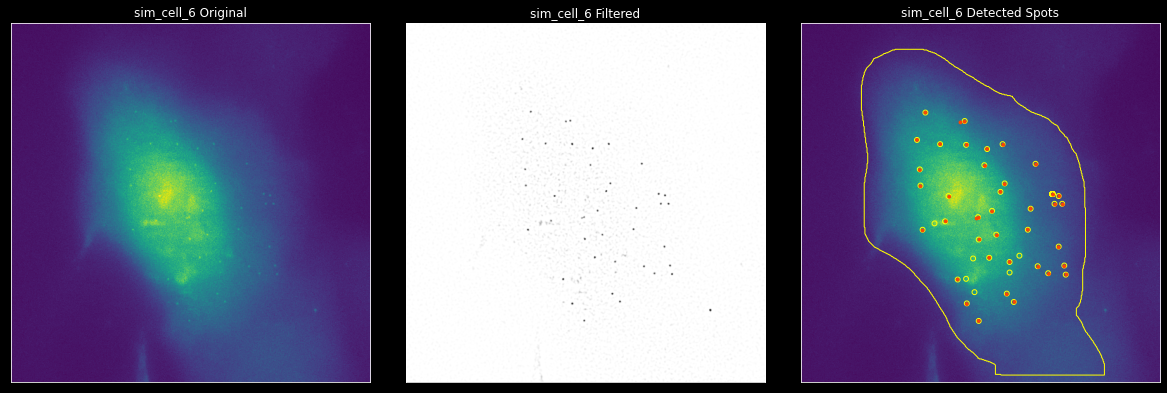

mask time: 7  sec


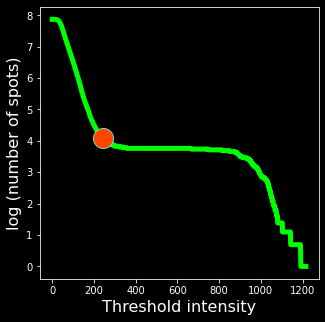

The number of detected trajectories is:  44
The selected intensity threshold is:  243.0 

tracking time: 4  sec
intensity calculation time: 1  sec


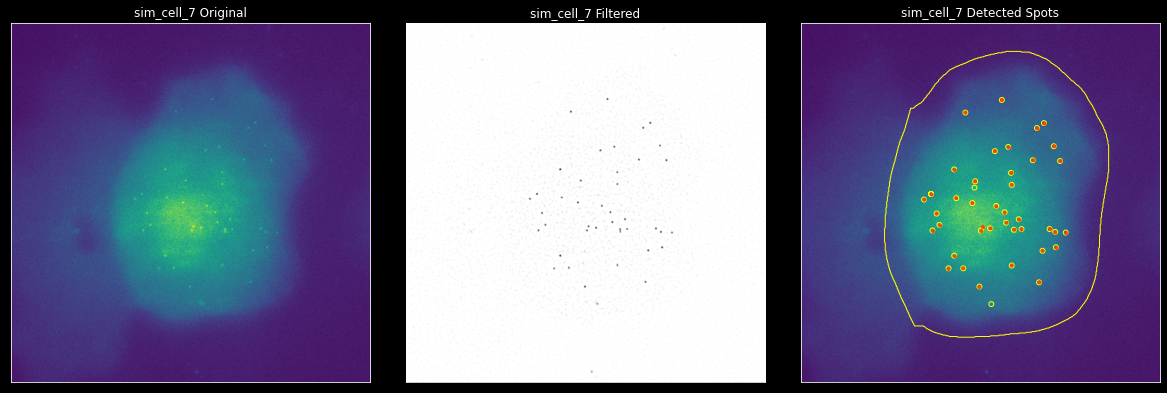

In [21]:
list_DataFrame_particles_intensities= []
list_array_intensities = []
list_time_vector = []
for i in tqdm(range(0,number_images)): 
    selected_video = imread(path_files[i]) # Loading the video
    DataFrame_particles_intensities, array_intensities, time_vector, mean_intensities,std_intensities, mean_intensities_normalized, std_intensities_normalized = rsp.PipelineTracking(selected_video,particle_size=particle_detection_size,file_name=list_files_names[i],selected_channel=0,intensity_calculation_method =intensity_calculation_method, mask_selection_method = mask_selection_method,show_plot=show_plot,use_optimization_for_tracking=use_optimization_for_tracking,real_positions_dataframe = list_df_real_positions[i],average_cell_diameter=average_cell_diameter,print_process_times=1,min_percentage_time_tracking=min_percentage_time_tracking,dataframe_format=dataframe_format).run()    
    list_DataFrame_particles_intensities.append(DataFrame_particles_intensities)
    list_array_intensities.append(array_intensities)
    list_time_vector.append(time_vector)

# Dataframe

In [22]:
list_DataFrame_particles_intensities[0].head()

cell_number  particle  frame  red_int_mean  green_int_mean  blue_int_mean  \
0            0         0      0        222.24          554.74            0.0   
1            0         0      1        249.68          707.74            0.0   
2            0         0      2        214.34          481.98            0.0   
3            0         0      3        267.94          574.22            0.0   
4            0         0      4        231.30          309.10            0.0   

   red_int_std  green_int_std  blue_int_std    x    y  SNR_red  SNR_green  \
0       272.03         768.15           0.0  311  142     2.86       1.17   
1       273.80         722.01           0.0  310  141     2.47       1.59   
2       285.03         605.16           0.0  311  141     2.31       1.37   
3       281.12         509.13           0.0  311  142     2.68       1.45   
4       249.19         691.48           0.0  311  141     2.34       0.70   

   SNR_blue  background_int_mean_red  background_int_mean_green  \
0       0.0                  1341.45                    3853.30   
1       0.0                  1325.21                    3774.61   
2       0.0                  1328.34                    3797.04   
3       0.0                  1345.80                    3851.93   
4       0.0                  1348.75                    3893.27   

   background_int_mean_blue  background_int_std_red  background_int_std_green  \
0                       0.0                   80.75                    435.04   
1                       0.0                  109.04                    431.63   
2                       0.0                   98.49                    325.09   
3                       0.0                   99.19                    380.69   
4                       0.0                   95.37                    390.75   

   background_int_std_blue  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0

# Comparing intensity distributions

## "Real" intensities from SSA

In [23]:
selected_time_point = 0 #simulation_time_in_sec-1

In [24]:
def remove_extrema(vector ,max_percentile = 98):
    '''This function is intended to remove extrema data given by the min and max percentiles specified by the user'''
    vector = vector [vector>0]
    max_val = np.percentile(vector, max_percentile)
    new_vector = vector [vector< max_val] # = np.percentile(vector,max_percentile)
    print(0 ,round(max_val,2))
    return new_vector

In [25]:
ssa_trajectories = np.load(str(trajectories_dir))
ssa_trajectories_timePoint = ssa_trajectories[:,selected_time_point].flatten()
#ssa_trajectories_timePoint= remove_extrema(ssa_trajectories_timePoint)
ssa_trajectories_timePoint_normalized = (ssa_trajectories_timePoint-np.amin(ssa_trajectories_timePoint))/ (np.amax(ssa_trajectories_timePoint)-np.amin(ssa_trajectories_timePoint))

## Recovered intensities from tracking

In [26]:
all_cells_green_int = np.array([])
for i in range(0,number_images): 
    all_cells_green_int = np.append(all_cells_green_int,list_array_intensities[i][:,selected_time_point,1].flatten())   
all_cells_green_int = all_cells_green_int[all_cells_green_int>0]
all_cells_green_int= remove_extrema(all_cells_green_int)
all_cells_green_int_normalized = (all_cells_green_int-np.amin(all_cells_green_int))/ (np.amax(all_cells_green_int)-np.amin(all_cells_green_int))

0 1015.92


## Loading intensities from image. "Perfect tracking"

In [27]:
# Extracting the number of real simulations from folder name
path_str = str(output_directory_name)                    # path
ind_str_start = path_str.find('_ns_') +4                # start index in string. "ns" stands for number of spots in the folder storing the simulated data.
ind_str_end = path_str.find('_diff')                    # end index in string. "diff" stands for diffusion constant in the folder storing the simulated data.
max_numbers_spots = int(path_str[ind_str_start:ind_str_end])   # number of spots per cell

#Pre-allocating memory
intensity_values_in_image = np.zeros((number_images,max_numbers_spots)) # pre-allocating memory for intensity

for i in range(0,number_images):
    for j in range (0,max_numbers_spots):
        file_name = str(output_directory_name.joinpath('sim_cell_'+str(i)+'_df.csv'))
        df_intensities_real = pd.read_csv(file_name)  
        intensity_values_in_image[i,j] = df_intensities_real[df_intensities_real['particle'] ==j].green_int_mean.values[selected_time_point] 
intensity_values_in_image_flat = intensity_values_in_image.flatten()
intensity_values_in_image_flat =  intensity_values_in_image_flat[intensity_values_in_image_flat>0]
intensity_values_in_image_flat= remove_extrema(intensity_values_in_image_flat)
intensity_values_in_image_normalized = (intensity_values_in_image_flat-np.amin(intensity_values_in_image_flat))/ (np.amax(intensity_values_in_image_flat)-np.amin(intensity_values_in_image_flat)).flatten()

0 988.42


In [28]:
def extract_intensity_from_dataframe(dataframe_path, number_images,selected_time=0,selected_field='green_int_mean', remove_negative_values=True,remove_extreme_values=True):
    list_with_extracted_data = []
    for i in range(0,number_images):
        file_name = str(dataframe_path.joinpath('sim_cell_'+str(i)+'_df.csv'))
        temporal_dataframe = pd.read_csv(file_name)  
        list_with_extracted_data.append (temporal_dataframe.loc[(temporal_dataframe['frame']==selected_time)][selected_field].values)
    extracted_data = np.concatenate(list_with_extracted_data)
    # Negative values may appear if the intensity in the background is higher than the intensity in the spot. This option allows to remove negative values.
    if remove_negative_values == True:
        extracted_data =  extracted_data[extracted_data>=0] 
    # To plot the histogram, we could remove extreme values. Extreme values are defined as those above the 98 percentile. 
    if remove_extreme_values==True:
        extracted_data= remove_extrema(extracted_data)  
    # Option to normalize data to the maximum value.
    normalized_extracted_data = (extracted_data-np.min(extracted_data))/ (np.max(extracted_data)-np.min(extracted_data))  
    return extracted_data,normalized_extracted_data

In [29]:
intensity_values_in_image_flat,intensity_values_in_image_normalized =  extract_intensity_from_dataframe(dataframe_path=output_directory_name, number_images=number_images,selected_time=0,selected_field='green_int_mean')

0 988.42


# Intensity histograms with au

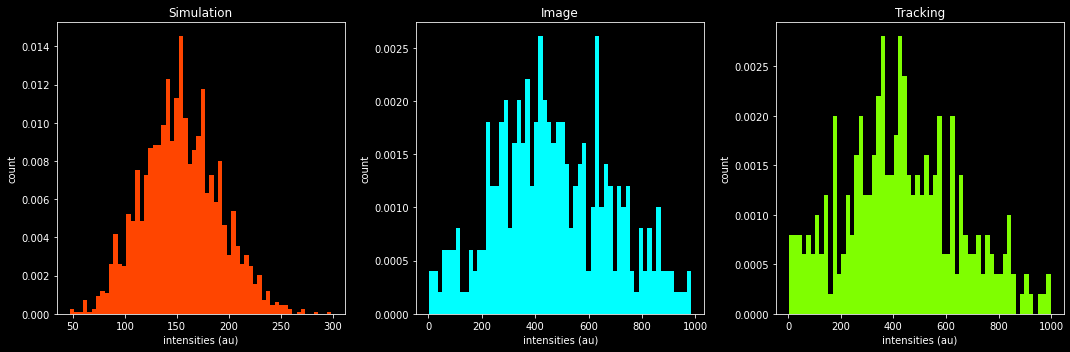

In [30]:
# plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].hist(ssa_trajectories_timePoint,bins=60,density=True, stacked=True, color='orangered' )     
axes[0].set(title='Simulation')
axes[0].set(xlabel='intensities (au)')
axes[0].set(ylabel='count')

axes[1].hist(intensity_values_in_image_flat,bins=60,density=True, stacked=True, color='cyan' )     
axes[1].set(title='Image')
axes[1].set(xlabel='intensities (au)')
axes[1].set(ylabel='count')

axes[2].hist(all_cells_green_int,bins=60,density=True, stacked=True, color='chartreuse' )     
axes[2].set(title='Tracking')
axes[2].set(xlabel='intensities (au)')
axes[2].set(ylabel='count')
plt.tight_layout()

## Normalizing intensities to 1.

$ X_{norm} = \frac{X -min(X)}{max(X) - min(X)} $

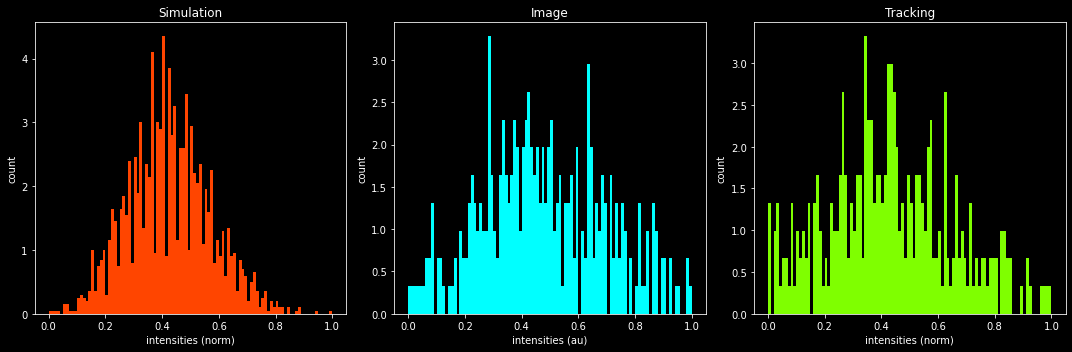

In [31]:
# plotting normalized intensities
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].hist(ssa_trajectories_timePoint_normalized,bins=100,density=True, stacked=True, color='orangered' )     
axes[0].set(title='Simulation')
axes[0].set(xlabel='intensities (norm)')
axes[0].set(ylabel='count')

axes[1].hist(intensity_values_in_image_normalized,bins=100,density=True, stacked=True, color='cyan' )     
axes[1].set(title='Image')
axes[1].set(xlabel='intensities (au)')
axes[1].set(ylabel='count')

axes[2].hist(all_cells_green_int_normalized,bins=100,density=True, stacked=True, color='chartreuse' )     
axes[2].set(title='Tracking')
axes[2].set(xlabel='intensities (norm)')
axes[2].set(ylabel='count')

plt.tight_layout()

### Statisics from normalized distributions

In [32]:
print('mean ssa:              ', np.round(np.mean(ssa_trajectories_timePoint_normalized),3) )
print('mean perfect tracking: ', np.round(np.mean(intensity_values_in_image_normalized),3)  )
print('mean tracking:         ', np.round(np.mean(all_cells_green_int_normalized),3)  )

mean ssa:               0.426
mean perfect tracking:  0.475
mean tracking:          0.43


In [33]:
print('std ssa:              ', np.round(np.std(ssa_trajectories_timePoint_normalized),3) )
print('std perfect tracking: ', np.round(np.std(intensity_values_in_image_normalized),3)  )
print('std tracking:         ', np.round(np.std(all_cells_green_int_normalized),3)  )

std ssa:               0.146
std perfect tracking:  0.219
std tracking:          0.222


## Cummulative frequencies

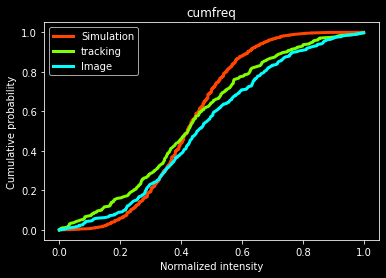

Number of spots for Simulation: 2000
Number of spots recovered from tracking: 301
Number of spots recovered from image: 305


In [34]:
# Data
data1 = ssa_trajectories_timePoint_normalized
data_sorted_1 = np.sort(data1)
p_1 =np.linspace(0, 1, len(data1), endpoint=False)

data2 = all_cells_green_int_normalized
data_sorted_2 = np.sort(data2)
p_2 =np.linspace(0, 1, len(data2), endpoint=False)

data3 = intensity_values_in_image_normalized
data_sorted_3 = np.sort(data3)
p_3 =np.linspace(0, 1, len(data3), endpoint=False)

# Plotting
plt.plot(data_sorted_1, p_1, 'orangered',linewidth=3,label ='Simulation')
plt.plot(data_sorted_2, p_2,'chartreuse',linewidth=3,label ='tracking')
plt.plot(data_sorted_3, p_3,'cyan',linewidth=3,label ='Image')

plt.legend()
plt.title('cumfreq')
plt.ylabel('Cumulative probability')
plt.xlabel('Normalized intensity')
plt.show()

# Print number of spots
print('Number of spots for Simulation:',len(data1))
print('Number of spots recovered from tracking:',len(data2))
print('Number of spots recovered from image:',len(data3))

## Comparison using the KS-distance

In [35]:
# Calculating Kolmogorov distance

ks_distance = scipy.stats.kstest(data1,data2).statistic
print('The KS-distance between SSA and tracking is:' , round(ks_distance,2))

ks_distance = scipy.stats.kstest(data1,data3).statistic
print('The KS-distance between SSA and image is:' , round(ks_distance,2))

#ks_distance = scipy.stats.kstest(data3,data2).statistic
#print('The KS-distance between image and tracking is:' , round(ks_distance,2))

The KS-distance between SSA and tracking is: 0.12
The KS-distance between SSA and image is: 0.19


## Comparison using the Anderson-Darling distance


In [36]:
ad_distance,_,_ = scipy.stats.anderson_ksamp([data1,data2],midrank=False)
print('The AD-distance between SSA and tracking is:' , round(ad_distance,2))

ad_distance,_,_ = scipy.stats.anderson_ksamp([data1,data3],midrank=False)
print('The AD-distance between SSA and image is:' , round(ad_distance,2))

The AD-distance between SSA and tracking is: 19.46
The AD-distance between SSA and image is: 29.09


#
## Comparison using likelihood function
#

In [37]:
def LL_fun(real_data,simulation_data,nbins=30):
    hist_exp_data, hist_exp_bins = np.histogram( real_data , bins=nbins)
    dist_sim_data, dist_sim_bins = np.histogram(simulation_data, bins=hist_exp_bins, density=True)
    dist_sim_data[dist_sim_data ==0] = 1e-7
    LL_int_distb = np.dot(hist_exp_data,np.log(dist_sim_data))    # likelihood function for comparing distributions
    return LL_int_distb


In [38]:
## LOG LIKELIHOOD OF THE INTENSITY DISTRIBUTIONS

LL_ssa_tracking = LL_fun(real_data= data_sorted_1,simulation_data=data_sorted_2,nbins=100)
print('The Likelihood between SSA and tracking is:' , round(LL_ssa_tracking,2))

LL_ssa_img = LL_fun(real_data=data_sorted_1, simulation_data=data_sorted_3,nbins=100)
print('The Likelihood between SSA and image is:' , round(LL_ssa_img,2))

The Likelihood between SSA and tracking is: 99.39
The Likelihood between SSA and image is: -97.43


# Scatter Plots

In [39]:
def plot_scatter_spots_cell_size(x,y,plot_title,selected_color = '#1C00FE',xlabel='',ylabel=''):
    r, p = stats.pearsonr(x, y)
    df_join_distribution = pd.DataFrame({'X':x,'Y':y})
    #plt.figure(figsize=(6,5))
    sns.set(font_scale = 1.3)
    b = sns.jointplot(data=df_join_distribution, y='Y', x='X', color= selected_color , marginal_kws=dict(bins=40, rug=True))
    b.plot_joint(sns.rugplot, height=0, color=[0.7,0.7,0.7], clip_on=True)
    b.plot_joint(sns.kdeplot, color=[0.5,0.5,0.5], levels=5)
    b.plot_joint(sns.regplot,scatter_kws={'color': 'orangered',"s":10, 'marker':'o'}, line_kws={'color': selected_color,'lw': 2} )
    blank_plot, = b.ax_joint.plot([], [], linestyle="", alpha=0)
    b.ax_joint.legend([blank_plot],['r={:.2f}'.format( np.round(r,2))],loc='upper left',)
    b.ax_joint.set_xlim(np.percentile(x,1), np.percentile(x,99))
    b.ax_joint.set_ylim(np.percentile(y,1), np.percentile(y,99))
    b.fig.suptitle(plot_title)
    b.ax_joint.set_xlabel(xlabel)
    b.ax_joint.set_ylabel(ylabel)
    b.ax_joint.collections[0].set_alpha(0)
    b.fig.tight_layout()
    b.fig.subplots_adjust(top=0.92) 
    #name_plot = plot_title +'.pdf'  
    #plt.savefig(name_plot, transparent=False,dpi=1200, bbox_inches = 'tight', format='pdf')
    plt.show()
    #pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))
    return

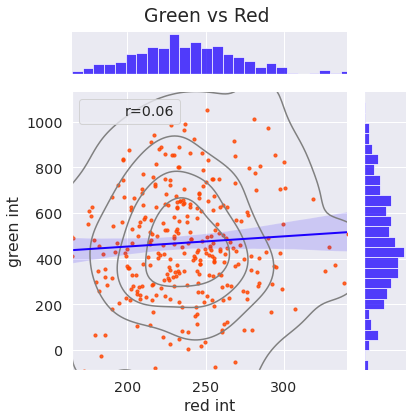

In [40]:
# Scatter plots intensity comparing all channels
#red_int_mean	green_int_mean	blue_int_mean	red_int_std	green_int_std	blue_int_std	x	y	SNR_red	SNR_green	SNR_blue	background_int_mean_red	background_int_mean_green	background_int_mean_blue	background_int_std_red	background_int_std_green	background_int_std_blue
int_red,_ =  extract_intensity_from_dataframe(dataframe_path=output_directory_name, number_images=number_images,selected_time=0,selected_field='red_int_mean', remove_negative_values=False,remove_extreme_values=False)
int_green,_ =  extract_intensity_from_dataframe(dataframe_path=output_directory_name, number_images=number_images,selected_time=0,selected_field='green_int_mean', remove_negative_values=False,remove_extreme_values=False)
plot_scatter_spots_cell_size(int_red,int_green,plot_title='Green vs Red',selected_color = '#1C00FE',xlabel='red int',ylabel='green int')

## <span style="color:lightgreen">Channel 1</span>

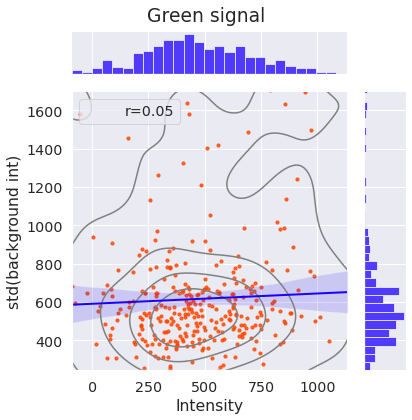

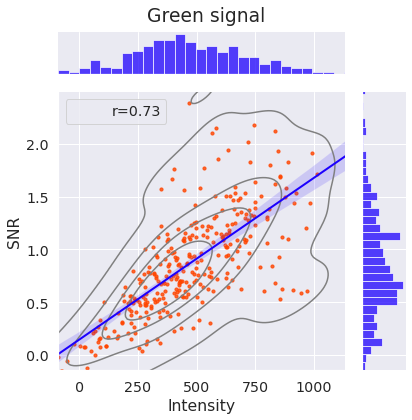

In [41]:
# Scatter plots intensity comparing all channels # background_int_std_green #SNR_green
background,_ =  extract_intensity_from_dataframe(dataframe_path=output_directory_name, number_images=number_images,selected_time=0,selected_field='background_int_std_green', remove_negative_values=False,remove_extreme_values=False)
intensity,_ =  extract_intensity_from_dataframe(dataframe_path=output_directory_name, number_images=number_images,selected_time=0,selected_field='green_int_mean', remove_negative_values=False,remove_extreme_values=False)
plot_scatter_spots_cell_size(intensity,background,plot_title='Green signal',selected_color = '#1C00FE',ylabel='std(background int)',xlabel='Intensity')

# Scatter plots intensity comparing all channels # background_int_std_green #SNR_green
SNR,_ =  extract_intensity_from_dataframe(dataframe_path=output_directory_name, number_images=number_images,selected_time=0,selected_field='SNR_green', remove_negative_values=False,remove_extreme_values=False)
intensity,_ =  extract_intensity_from_dataframe(dataframe_path=output_directory_name, number_images=number_images,selected_time=0,selected_field='green_int_mean', remove_negative_values=False,remove_extreme_values=False)
plot_scatter_spots_cell_size(intensity,SNR,plot_title='Green signal',selected_color = '#1C00FE',xlabel='Intensity',ylabel='SNR')

## <span style="color:red">Channel 0</span>

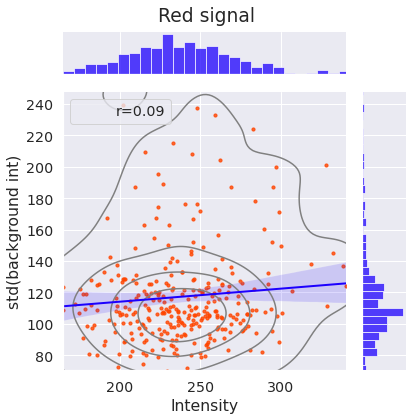

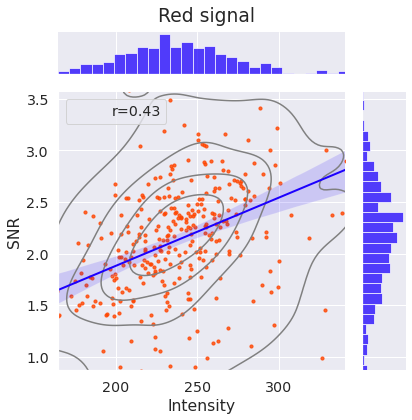

In [42]:

# Scatter plots intensity comparing all channels # background_int_std_green #SNR_green
background,_ =  extract_intensity_from_dataframe(dataframe_path=output_directory_name, number_images=number_images,selected_time=0,selected_field='background_int_std_red', remove_negative_values=False,remove_extreme_values=False)
intensity,_ =  extract_intensity_from_dataframe(dataframe_path=output_directory_name, number_images=number_images,selected_time=0,selected_field='red_int_mean', remove_negative_values=False,remove_extreme_values=False)
plot_scatter_spots_cell_size(intensity,background,plot_title='Red signal',selected_color = '#1C00FE',ylabel='std(background int)',xlabel='Intensity')

# Scatter plots intensity comparing all channels # background_int_std_green #SNR_green
SNR,_ =  extract_intensity_from_dataframe(dataframe_path=output_directory_name, number_images=number_images,selected_time=0,selected_field='SNR_red', remove_negative_values=False,remove_extreme_values=False)
intensity,_ =  extract_intensity_from_dataframe(dataframe_path=output_directory_name, number_images=number_images,selected_time=0,selected_field='red_int_mean', remove_negative_values=False,remove_extreme_values=False)
plot_scatter_spots_cell_size(intensity,SNR,plot_title='Red signal',selected_color = '#1C00FE',xlabel='Intensity',ylabel='SNR')